In [1]:
import tensorflow as tf
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, AveragePooling2D,
                                     GlobalAveragePooling2D, BatchNormalization,
                                     Activation, Add, Concatenate, Dense, Dropout,
                                     Multiply, Reshape)
import os, kagglehub

# Disable XLA JIT (to avoid huge pinned‐host allocs)
tf.config.optimizer.set_jit(False)

# GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(" GPU memory growth enabled")
else:
    print(" No GPU detected")

mixed_precision.set_global_policy('mixed_float16')
print(" Mixed precision policy:", mixed_precision.global_policy())


 GPU memory growth enabled
 Mixed precision policy: <DTypePolicy "mixed_float16">


In [2]:
import os
import kagglehub

path = kagglehub.dataset_download("nafishamoin/bangladeshi-crops-disease-dataset")
print(" Raw dataset path:", path)

main_folder = os.listdir(path)[0]
main_path = os.path.join(path, main_folder)
print(" Main folder:", main_folder)
print("Contents of main folder:", os.listdir(main_path)[:5])

image_root = os.path.join(main_path, "Crop___DIsease")
print(" Image root folder:", image_root)

classes = os.listdir(image_root)
print(" Classes found:", classes[:10])

 Raw dataset path: /kaggle/input/bangladeshi-crops-disease-dataset
 Main folder: CropDisease
Contents of main folder: ['Crop___DIsease']
 Image root folder: /kaggle/input/bangladeshi-crops-disease-dataset/CropDisease/Crop___DIsease
 Classes found: ['Wheat___Yellow_Rust', 'Potato___Healthy', 'Corn___Healthy', 'Wheat___Brown_Rust', 'Corn___Gray_Leaf_Spot', 'Rice___Brown_Spot', 'Wheat___Healthy', 'Rice___Leaf_Blast', 'Potato___Late_Blight', 'Rice___Healthy']


In [3]:
data_root = os.path.join(main_path, "Crop___DIsease")

In [4]:
#Load datasets with one hot labels
import tensorflow as tf

batch_size = 8
img_size   = (160, 160)

dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_root,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)
dataset_val = tf.keras.preprocessing.image_dataset_from_directory(
    data_root,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

print("Train element spec:", dataset_train.element_spec)

Found 31053 files belonging to 15 classes.
Using 24843 files for training.
Found 31053 files belonging to 15 classes.
Using 6210 files for validation.
Train element spec: (TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))


In [5]:
num_classes = dataset_train.element_spec[1].shape[-1]
print("Detected num_classes =", num_classes)

Detected num_classes = 15


In [6]:
#Preprocessing
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = (
    dataset_train
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(500)
    .prefetch(1)
)

val_ds = (
    dataset_val
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .prefetch(1)
)


In [7]:
import tensorflow as tf
import math
from tensorflow.keras import layers, regularizers, backend as K, Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, AveragePooling2D,
    GlobalAveragePooling2D, Dense, Dropout, Concatenate,Reshape, Dot, Add, Lambda
)

In [8]:
def rsa_attention(x, reg_l2=1e-4, reg_l1=1e-4, name=None):
    C = x.shape[-1]
    H = x.shape[1]
    W = x.shape[2]
    N = H * W

    f = Conv2D(C,1,padding='same',use_bias=True,
               kernel_regularizer=regularizers.l2(reg_l2),
               bias_regularizer   =regularizers.l1(reg_l1),
               name=(name+"_f" if name else None))(x)
    g = Conv2D(C,1,padding='same',use_bias=True,
               kernel_regularizer=regularizers.l2(reg_l2),
               bias_regularizer   =regularizers.l1(reg_l1),
               name=(name+"_g" if name else None))(x)
    h = Conv2D(C,1,padding='same',use_bias=True,
               kernel_regularizer=regularizers.l2(reg_l2),
               bias_regularizer   =regularizers.l1(reg_l1),
               name=(name+"_h" if name else None))(x)

    f_flat = Reshape((N, C), name=(name+"_reshape_f" if name else None))(f)
    g_flat = Reshape((N, C), name=(name+"_reshape_g" if name else None))(g)
    h_flat = Reshape((N, C), name=(name+"_reshape_h" if name else None))(h)

    scores = Dot(axes=(2,2), name=(name+"_score" if name else None))([f_flat, g_flat])

    inv_sqrt_C = 1.0 / math.sqrt(C)
    scores = Lambda(lambda t: t * inv_sqrt_C,
                    name=(name+"_scale" if name else "rsa_scale"))(scores)

    alpha = Activation('softmax', name=(name+"_softmax" if name else "rsa_softmax"))(scores)
    o_flat = Dot(axes=(2,1), name=(name+"_apply" if name else "rsa_apply"))([alpha, h_flat])
    o = Reshape((H, W, C), name=(name+"_out" if name else "rsa_out"))(o_flat)
    return o

In [9]:
#Model building blocks

def residual_block(x, filters, stride=1):
    shortcut = x
    x = Conv2D(filters,3,strides=stride,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x); x=Activation('relu')(x)
    x = Conv2D(filters,3,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    if stride!=1 or shortcut.shape[-1]!=filters:
        shortcut = Conv2D(filters,1,strides=stride,use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x,shortcut]); return Activation('relu')(x)

def residual_block_group(x, f, n, stride=1):
    x = residual_block(x,f,stride)
    for _ in range(1,n):
        x = residual_block(x,f,1)
    return x

def dense_block(x, layers_n, g_rate):
    feats = [x]
    for _ in range(layers_n):
        y = Concatenate()(feats)
        y = BatchNormalization()(y); y=Activation('relu')(y)
        y = Conv2D(4*g_rate,1,padding='same',use_bias=False)(y)
        y = BatchNormalization()(y); y=Activation('relu')(y)
        y = Conv2D(g_rate,3,padding='same',use_bias=False)(y)
        feats.append(y)
    return Concatenate()(feats)

def transition_layer(x):
    x = BatchNormalization()(x)
    x = Conv2D(x.shape[-1]//2,1,padding='same',use_bias=False)(x)
    return AveragePooling2D(2,2)(x)


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks, optimizers, losses
import os



def build_rsa_derefnet(input_shape=(160,160,3), num_classes=15, growth_rate=12):
    i = Input(shape=input_shape)

    # Initial conv
    x0 = Conv2D(32,3,padding='same',use_bias=False)(i)
    x0 = BatchNormalization()(x0); x0 = Activation('relu')(x0)

    # Residual stream with RSA
    r1 = residual_block_group(x0,  64, 1, stride=1)
    p1 = AveragePooling2D(pool_size=4)(r1)
    a1 = rsa_attention(p1, name="res1")
    r2 = residual_block_group(a1, 128, 1, stride=2)
    p2 = AveragePooling2D(pool_size=2)(r2)
    a2 = rsa_attention(p2, name="res2")
    r3 = residual_block_group(a2, 256, 1, stride=2)
    g_r = GlobalAveragePooling2D()(r3)

    # Dense stream with RSA
    d1 = Conv2D(32,3,padding='same',use_bias=False)(i)
    d1 = BatchNormalization()(d1); d1 = Activation('relu')(d1)
    d1 = MaxPooling2D(2)(d1)
    db1 = dense_block(d1, 3, growth_rate)
    a3 = rsa_attention(db1, name="dens1")
    t1 = transition_layer(a3)

    db2 = dense_block(t1, 3, growth_rate)
    a4 = rsa_attention(db2, name="dens2")
    t2 = transition_layer(a4)

    db3 = dense_block(t2, 5, growth_rate)
    a5 = rsa_attention(db3, name="dens3")
    g_d = GlobalAveragePooling2D()(a5)

    # Fuse & classify
    f = Concatenate()([g_r, g_d])
    f = Dropout(0.5)(f)
    out = Dense(num_classes, activation='softmax', dtype='float32')(f)

    return Model(i, out)

# Learning rate schedule
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

# Build and compile the model
model = build_rsa_derefnet(
    input_shape=(160,160,3),
    num_classes=num_classes,
    growth_rate=12
)
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0),
    loss=losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)



history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)


Epoch 1/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 507s 125ms/step - accuracy: 0.6774 - loss: 1.1886 - val_accuracy: 0.8214 - val_loss: 0.6041
Epoch 2/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 344s 104ms/step - accuracy: 0.8640 - loss: 0.5451 - val_accuracy: 0.9298 - val_loss: 0.3067
Epoch 3/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 343s 103ms/step - accuracy: 0.8914 - loss: 0.4423 - val_accuracy: 0.9287 - val_loss: 0.3287
Epoch 4/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 380s 103ms/step - accuracy: 0.9029 - loss: 0.4009 - val_accuracy: 0.9398 - val_loss: 0.2811
Epoch 5/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 344s 104ms/step - accuracy: 0.9167 - loss: 0.3505 - val_accuracy: 0.9496 - val_loss: 0.2610
Epoch 6/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 378s 102ms/step - accuracy: 0.9206 - loss: 0.3335 - val_accuracy: 0.9490 - val_loss: 0.2566
Epoch 7/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 381s 102ms/step - accuracy: 0.9245 - loss: 0.3255 - val_accuracy: 0.9512 - val_loss: 0.2538
Epoch 8/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 342s 103ms/step - ac

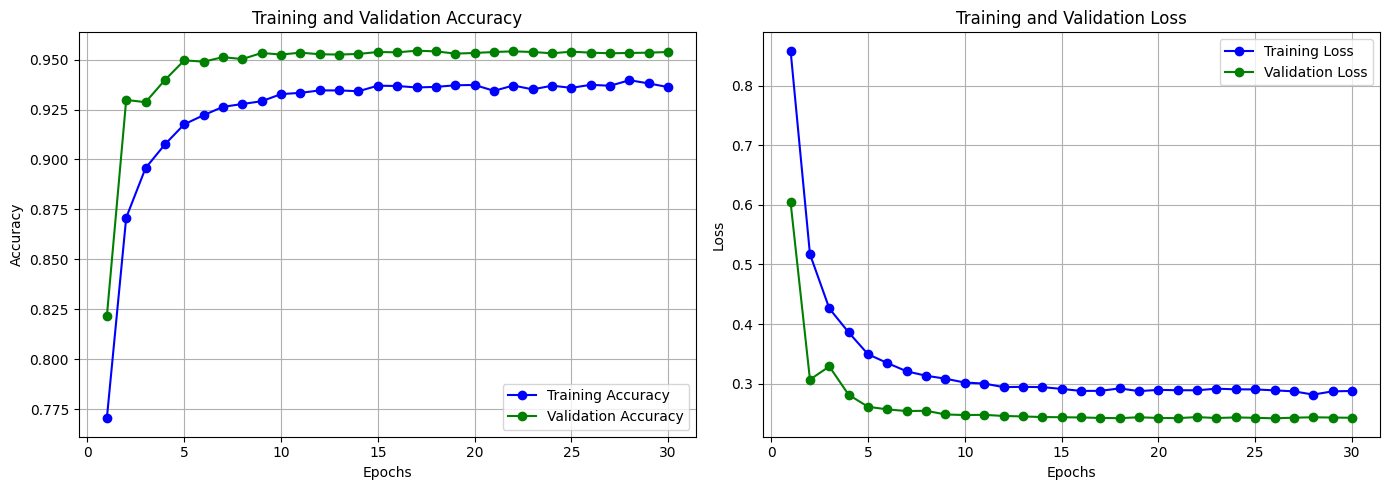

In [11]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 160, 160,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 160, 160,  │        864 │ cast_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 160, 160,  │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 160, 160,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 80, 80,    │          0 │ activation_7[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 80, 80,    │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 80, 80,    │      1,536 │ activation_8[0][… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        192 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 80, 80,    │      5,184 │ activation_9[0][… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 80, 80,    │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 44)               │            │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        176 │ concatenate_1[0]… │
│ (BatchNormalizatio… │ 44)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 44)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 80, 80,    │      2,112 │ activation_10[0]

 Total params: 4,276,617 (16.31 MB)

 Trainable params: 1,423,778 (5.43 MB)

 Non-trainable params: 5,278 (20.62 KB)

 Optimizer params: 2,847,561 (10.86 MB)